In [1]:
%cd ..
from datasets.loaders import build_dataloaders
from models import build_model
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
import cv2
from matplotlib import pyplot as plt
from train import get_cfg
from prodict import Prodict
import torch
import numpy as np
plt.style.use('dark_background')

/home/drumsnchocolate/miniconda3/envs/segment_anything/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/drumsnchocolate/Documents/Studie/Master/2022-2023/Thesis/Final Project/implementation/segment_anything


In [2]:
args = Prodict(config='finetune/configs/test_ade20k.yaml', cfg_options=None)
cfg = get_cfg(args)
dataloaders = build_dataloaders(cfg)
model = build_model(cfg)
mask_generator = SamAutomaticMaskGenerator(model)
samples, labels = next(iter(dataloaders['train']))


/home/drumsnchocolate/miniconda3/envs/segment_anything/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [3]:
def imshow(image, gray=False, alpha=1, ax=plt):
    if gray:
        ax.imshow(image.permute(1,2,0), cmap='gray', alpha=alpha)
    else:
        ax.imshow(image.permute(1,2,0), alpha=alpha)

def maskshow(mask, alpha=1, ax=plt):
    ax.imshow(mask, alpha=alpha, cmap='rainbow')

def get_mask(sample, mask_generator) -> torch.Tensor:
    masks = mask_generator.generate(np.array(sample.permute(1,2,0)))
    merged_mask = sum([mask['segmentation']*(i+1) for i, mask in enumerate(masks)])
    return torch.Tensor(merged_mask)

def show_label(sample, label, gray_sample=False, gray_label=False):
    imshow(sample, gray=gray_sample)
    imshow(label, alpha=0.5, gray=gray_label)
    plt.show()

def show_mask(sample, merged_mask, gray_sample=False):
    imshow(sample, gray=gray_sample)
    maskshow(merged_mask, alpha=0.5)
    plt.show()
    
def repeat(sample, n):
    return torch.cat([sample for _ in range(n)], dim=0)

In [5]:
merged_masks = [get_mask(sample, mask_generator) for sample in samples]


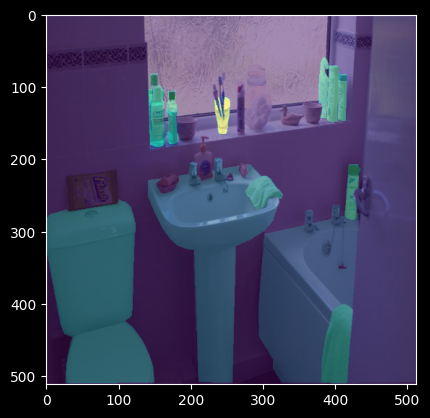

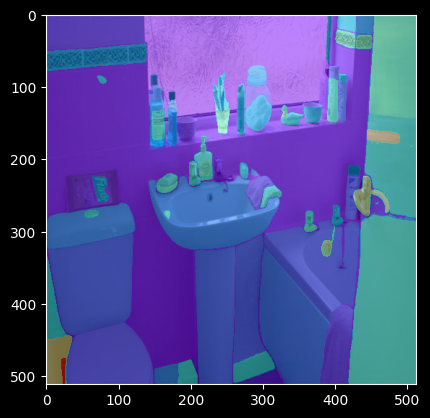

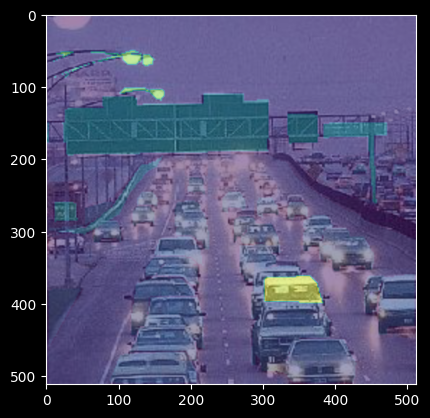

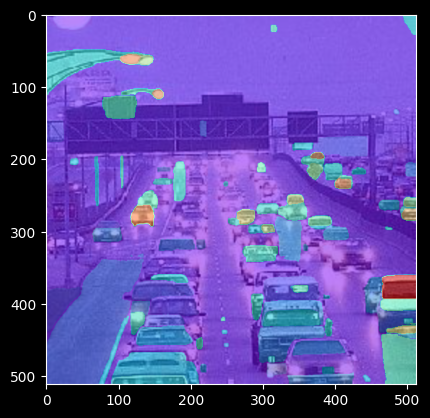

In [7]:

for sample, label, merged_mask in zip(samples, labels, merged_masks):
    show_label(sample, label)
    show_mask(sample, merged_mask)

# and now for CBIS-Binary

In [4]:
args = Prodict(config='finetune/configs/test_cbis-binary.yaml', cfg_options=None)
cfg = get_cfg(args)
dataloaders = build_dataloaders(cfg)
model = build_model(cfg)
mask_generator = SamAutomaticMaskGenerator(model)
samples, labels = next(iter(dataloaders['train']))

/home/drumsnchocolate/miniconda3/envs/segment_anything/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:

merged_masks = [get_mask(repeat(sample, 3), mask_generator) for sample in samples]


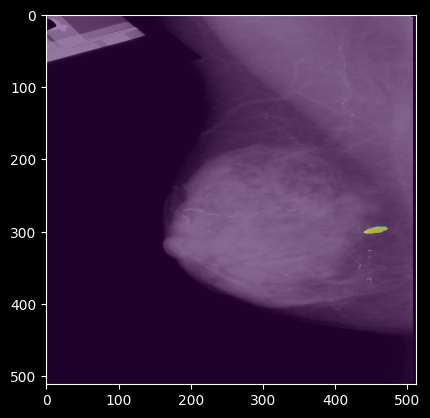

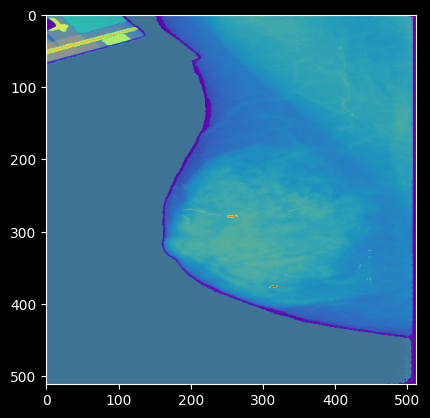

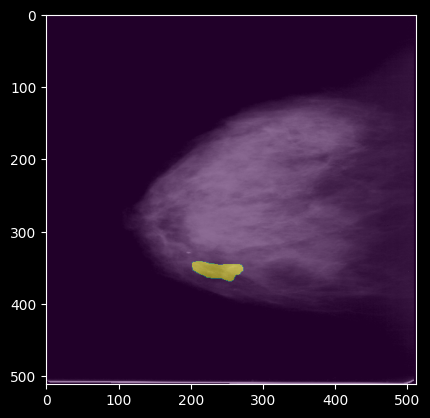

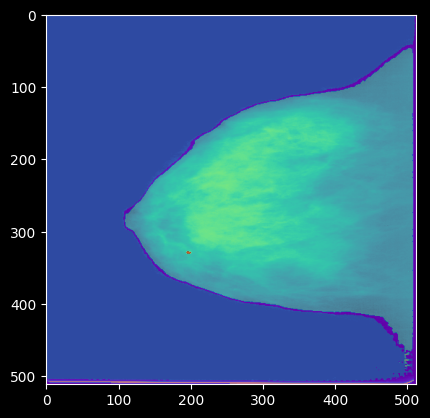

In [6]:
for sample, label, merged_mask in zip(samples, labels, merged_masks):
    show_label(repeat(sample, 3), label, gray_sample=True)
    show_mask(sample, merged_mask)


# and now for CBIS-Binary

In [ ]:
args = Prodict(config='finetune/configs/test_cbis-multi.yaml', cfg_options=None)
cfg = get_cfg(args)
dataloaders = build_dataloaders(cfg)
model = build_model(cfg)
mask_generator = SamAutomaticMaskGenerator(model)
samples, labels = next(iter(dataloaders['train']))

In [ ]:

merged_masks = [get_mask(repeat(sample, 3), mask_generator) for sample in samples]



In [ ]:
for sample, label, merged_mask in zip(samples, labels, merged_masks):
    show_label(repeat(sample, 3), label, gray_sample=True)
    show_mask(sample, merged_mask)